<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
# house = pd.read_csv('./housing.csv')

In [3]:
# A:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
for col in house.columns:
    if house[col].dtypes == object:
        print(f"For the column {col}, the unique values are {house[col].unique()}")

For the column MSZoning, the unique values are ['RL' 'RM' 'C (all)' 'FV' 'RH']
For the column Street, the unique values are ['Pave' 'Grvl']
For the column Alley, the unique values are [nan 'Grvl' 'Pave']
For the column LotShape, the unique values are ['Reg' 'IR1' 'IR2' 'IR3']
For the column LandContour, the unique values are ['Lvl' 'Bnk' 'Low' 'HLS']
For the column Utilities, the unique values are ['AllPub' 'NoSeWa']
For the column LotConfig, the unique values are ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
For the column LandSlope, the unique values are ['Gtl' 'Mod' 'Sev']
For the column Neighborhood, the unique values are ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
For the column Condition1, the unique values are ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
For the

In [5]:
for col in house.columns:
    if house[col].dtypes != object:
        print(f"For the column {col}, the unique values are {house[col].unique()}")

For the column Id, the unique values are [   1    2    3 ... 1458 1459 1460]
For the column MSSubClass, the unique values are [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
For the column LotFrontage, the unique values are [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
For the column LotArea, the unique values are [ 8450  9600 11250 ... 17217 13175  9717]
For the column OverallQual, the unique values are [ 7  6  8  5  9  4 10  3  1  2]
For the column OverallCond, 

In [6]:
len(house[house.isnull().sum(axis=1)>0])

1460

In [7]:
# remove non-residential area
residential = [True if ele in ['RL', 'RM', 'FV', 'RH'] else False for ele in house.MSZoning]
house_residential = house[residential].copy()
house_residential.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [8]:
# set LotFrontage nan value to 0, since there is no zero value exist, consider as input error, 0 feet is record as nan
house_residential.loc[house_residential.LotFrontage.isnull(),'LotFrontage'] = 0

In [9]:
house_residential['LotFrontage'].unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,   0.,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40.,  73.,  77.,
        64.,  94., 105.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

In [10]:
house_residential.loc[house_residential.Alley.isnull(),'Alley']='No_alley'

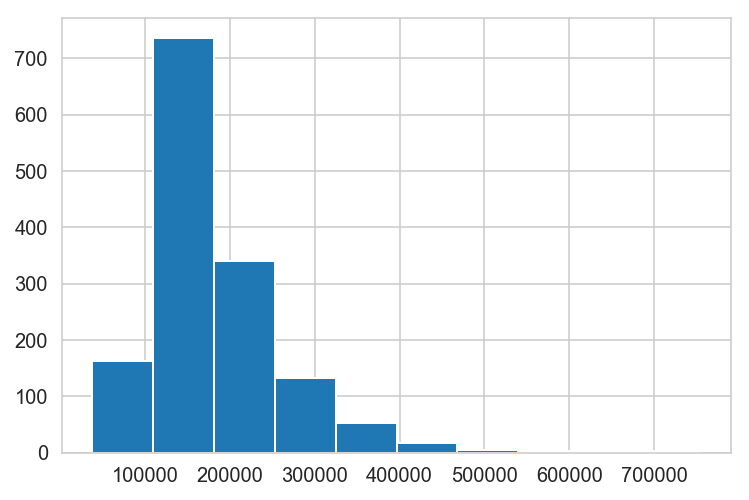

In [11]:
house_residential.SalePrice.hist()

In [12]:
# item 948 missing BsmtExposure 
house_residential.loc[house_residential.BsmtExposure.isnull(), ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0


In [13]:
# setting 948, 'BsmtExposure' = 'othr'
house_residential.loc[948, 'BsmtExposure'] = 'othr'

In [14]:
# item 332 missing BsmtFinType2 
house_residential.loc[house_residential.BsmtFinType2=='NA', ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,BsmtFullBath,BsmtHalfBath


In [15]:
# setting 332, 'BsmtFinType2' = 'othr'
house_residential.loc[332, 'BsmtFinType2'] = 'othr'

In [16]:
# set 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' as 'No' if is no basement
house_residential.loc[house_residential.BsmtQual.isnull(), ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = 'No_Bmt'

In [17]:
house_residential.BsmtFinType2.unique()

array(['Unf', 'BLQ', 'No_Bmt', 'ALQ', 'Rec', 'LwQ', 'GLQ', 'othr'],
      dtype=object)

In [18]:
house_residential.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [19]:
house_residential.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No_alley,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,No_alley,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,No_alley,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,No_alley,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,No_alley,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
house_residential.groupby('YrSold').agg({'Id':['count'], 'LotArea':['mean','std'], 'LotFrontage':['mean', 'std']})

Id       LotArea               LotFrontage           
       count          mean           std        mean        std
YrSold                                                         
2006     312  10492.467949   6419.414991   58.512821  33.125987
2007     328  10874.856707  11288.934501   57.679878  34.287746
2008     302  10570.056291  10737.100191   57.804636  36.778021
2009     336  10306.866071  12089.392452   55.812500  34.833728
2010     172  10254.005814   6412.938008   58.418605  34.703410

In [21]:
house_residential[house_residential.BsmtQual.isnull()][['BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF


In [22]:
house_residential.columns[house_residential.isnull().sum()>0]

Index(['MasVnrType', 'MasVnrArea', 'Electrical', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [23]:
house_residential.loc[house_residential.MasVnrType.isnull(),['MasVnrType','MasVnrArea' ]]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [24]:
house_residential.loc[house_residential.MasVnrType.isnull(),'MasVnrType'] = 'No_Mas'

In [25]:
house_residential.loc[house_residential.MasVnrType=='None','MasVnrType'] = 'No_Mas'

In [26]:
house_residential.loc[house_residential.MasVnrArea.isnull(),'MasVnrArea'] = 0

In [27]:
# fit the missing electrical with the most common type SBrkr
house_residential.loc[house_residential.Electrical.isnull(),'Electrical']= house_residential.Electrical.value_counts().index[0]

In [28]:
house_residential.loc[house_residential.FireplaceQu.isnull(),['Fireplaces','FireplaceQu']]

,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN
12,0,NaN
15,0,NaN
17,0,NaN
18,0,NaN
19,0,NaN
26,0,NaN
29,0,NaN


In [29]:
train_data = house_residential[house_residential.YrSold< 2010 ].copy()
test_data = house_residential[house_residential.YrSold == 2010 ].copy()


In [30]:
(len(train_data)+len(test_data)) == len(house_residential)

True

In [31]:
print((len(train_data), len(test_data)))

(1278, 172)


In [32]:
fixed_ch = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
            'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
            'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual', 'BsmtExposure',
            'TotalBsmtSF',  'BsmtFullBath', 'BsmtHalfBath','FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
            'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
            'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', 'MiscFeature',
            'MiscVal', 'SaleType', 'SaleCondition']

In [33]:
y_train = train_data.SalePrice
X_train = train_data[fixed_ch]

y_test = test_data.SalePrice
X_test = test_data[fixed_ch]

In [34]:
data_fixed.BsmtQual.unique()

NameError: name 'data_fixed' is not defined

In [ ]:
data_fixed.head()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: